# Set up

In [20]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Introduction to OpenAi Gymnasium

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [3]:
envs = gym.envs.registry
sorted(envs.keys())

['ALE/Adventure-ram-v5',
 'ALE/Adventure-v5',
 'ALE/AirRaid-ram-v5',
 'ALE/AirRaid-v5',
 'ALE/Alien-ram-v5',
 'ALE/Alien-v5',
 'ALE/Amidar-ram-v5',
 'ALE/Amidar-v5',
 'ALE/Assault-ram-v5',
 'ALE/Assault-v5',
 'ALE/Asterix-ram-v5',
 'ALE/Asterix-v5',
 'ALE/Asteroids-ram-v5',
 'ALE/Asteroids-v5',
 'ALE/Atlantis-ram-v5',
 'ALE/Atlantis-v5',
 'ALE/Atlantis2-ram-v5',
 'ALE/Atlantis2-v5',
 'ALE/Backgammon-ram-v5',
 'ALE/Backgammon-v5',
 'ALE/BankHeist-ram-v5',
 'ALE/BankHeist-v5',
 'ALE/BasicMath-ram-v5',
 'ALE/BasicMath-v5',
 'ALE/BattleZone-ram-v5',
 'ALE/BattleZone-v5',
 'ALE/BeamRider-ram-v5',
 'ALE/BeamRider-v5',
 'ALE/Berzerk-ram-v5',
 'ALE/Berzerk-v5',
 'ALE/Blackjack-ram-v5',
 'ALE/Blackjack-v5',
 'ALE/Bowling-ram-v5',
 'ALE/Bowling-v5',
 'ALE/Boxing-ram-v5',
 'ALE/Boxing-v5',
 'ALE/Breakout-ram-v5',
 'ALE/Breakout-v5',
 'ALE/Carnival-ram-v5',
 'ALE/Carnival-v5',
 'ALE/Casino-ram-v5',
 'ALE/Casino-v5',
 'ALE/Centipede-ram-v5',
 'ALE/Centipede-v5',
 'ALE/ChopperCommand-ram-v5',
 'ALE/

In [4]:
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [5]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [6]:
info

{}

In [7]:
img = env.render()
img.shape

(400, 600, 3)

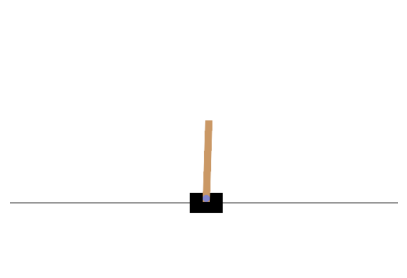

In [8]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img


plot_environment(env)
plt.show()

In [9]:
env.action_space

Discrete(2)

In [10]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Notice that the cart is now moving toward the right (`obs[1] > 1`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so will be likely to be titled toward the left in the next step.

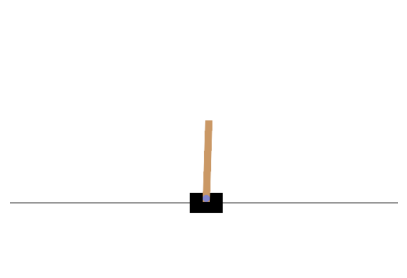

In [11]:
plot_environment(env)
plt.show()

The environment tells the agent how much reward it got during the last step.

In [12]:
reward

1.0

When the game is over, the environment returns `done=True`. In this case, it's not over yet.

In [13]:
done

False

Some environment wrappers may want to interrupt the environment early. Foe example, when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to `True`. In this case, it's not truncated yet. 

In [14]:
truncated

False

Finally, `info` is an environment-specific dictionary that can provides some extra information that you may find useful for debugging or for training. For example, in some games it may indicate hwo many lives the agent has. In our case though, it's empty.

In [15]:
info

{}

The sequences of steps between the moment the environment is reset until it's done or truncated is called an "episode". At the end of the episode (i.e., when `step()` returns `done=True` or `truncated=True`), you should reset the environment before you continue to use it.

In [16]:
if done or truncated:
    obs, info = env.reset()

## A simple hardcoded policy

Let's hardcode a simple policy that accelerate the cart to the left when the pole is tilted to the left and accelerate the cart to the right when the pole is titled ot the right.

In [17]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1


totals = []
for episode in range(500):
    episode_reward = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_reward += reward
        if done or truncated:
            break
    totals.append(episode_reward)

In [19]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

In [25]:
import matplotlib

matplotlib.rc("animation", html="jshtml")


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return (patch,)


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    animation = matplotlib.animation.FuncAnimation(
        fig,
        update_scene,
        fargs=(frames, patch),
        frames=len(frames),
        repeat=repeat,
        interval=interval,
    )
    plt.close()
    return animation


def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(42)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)


show_one_episode(basic_policy)